In [1]:
import pennylane as qml
import numpy as np
import torch
from torch import optim
from pennylane_ionq import SimulatorDevice
API_KEY = "1M2CfwlG0uQPCJCNulP2rGYd9JTlXLbS"

In [2]:
# functeion which conputes set of board, empty_rows, nonempty_rows
def status(horses,size):
    total_horses = horses 
    board = np.zeros((size,size))   
    row_list = [i for i in range(size)]

    nonempty_rows = [h[0] for h in total_horses]
    empty_rows = [x for x in row_list if x not in nonempty_rows]
    nonempty_rows.sort()

    for h in total_horses:
        board[h[0]][h[1]] = 1

    return board, empty_rows


In [3]:
# draw board
def draw(board):
    boxes = ['□', '◆']
    for row_board in board.tolist():
      for b in row_board:
        print(boxes[int(b)], end ='')
      print()

In [4]:
# convert (size**2,1) tensor -> nomalized (size,size) tensor
def nomalization(result):
    return (-torch.FloatTensor(result).reshape([4,4])+1)*.5

In [5]:
size = 4
num_qubits = size ** 2

dev = qml.device("default.qubit", wires= num_qubits)

@qml.qnode(dev)
def state_vec(weights, board,empty_rows):
    
    board = board.astype(int).reshape(1,-1).reshape([size**2,])
    qml.BasisStatePreparation(board, wires= range(num_qubits) )    

    for w in weights:
        th_count = 0
        n = size    
        for e in empty_rows:
            pivot = n * e # qubit 번호 구하기, board의 가로세로 사이즈 * row 번호
            for j in range(n):
                # qml.IsingXX(weights[th_count], wires = [pivot , pivot + j+1])
                qml.RX(w[th_count], wires = [pivot + j])
                th_count += 1

    return qml.probs()

In [6]:
@qml.qnode(dev, interface='torch')
def circuit(weights, board, empty_rows):


    board = board.astype(int).reshape(1,-1).reshape([size**2,])
    qml.BasisStatePreparation(board, wires= range(num_qubits) )    

    for w in weights:
        th_count = 0
        n = size    
        for e in empty_rows:
            pivot = n * e # qubit 번호 구하기, board의 가로세로 사이즈 * row 번호
            for j in range(n):
                # qml.IsingXX(weights[th_count], wires = [pivot , pivot + j+1])
                qml.RX(w[th_count], wires = [pivot + j])
                th_count += 1



    result = [qml.expval(qml.PauliZ(i)) for i in range(num_qubits)]
    return result

## Cost function (for 4X4 Board)

In [7]:
# 그냥 생노가다 cost function 
# numpy로 하다 보니 tensor의 특성이 묻힘 -> tensor 전용 함수를 사용해서 다시 범용적인 cost function을 세우는 것이 할일)
def cost_fn(result):
    ham = 0

    # 가로
    ham += abs(pow(result[4]+result[5]+result[6]+result[7]-2,2))
    ham += abs(pow(result[8]+result[9]+result[10]+result[11]-2,2))
    ham += abs(pow(result[12]+result[13]+result[14]+result[15]-2,2))
    # 세로
    ham += abs(pow(result[0]+result[4]+result[8]+result[12]-2,2))
    ham += abs(pow(result[1]+result[5]+result[9]+result[13]-2,2))
    ham += abs(pow(result[2]+result[6]+result[10]+result[14]-2,2))
    ham += abs(pow(result[3]+result[7]+result[11]+result[15]-2,2))
    # 대각
    ham += abs((result[0]+result[5]+result[10]+result[15]-4)*(result[0]+result[5]+result[10]+result[15]-2))
    ham += abs((result[4]+result[9]+result[14]-3)*(result[4]+result[9]+result[14]-1))
    ham += abs((result[1]+result[6]+result[11]-3)*(result[1]+result[6]+result[11]-1))
    ham += abs((result[2]+result[7]-2)*(result[2]+result[7]))
    ham += abs((result[8]+result[13]-2)*(result[8]+result[13]))
    
    ham += abs((result[12]+result[9]+result[6]+result[3]-4)*(result[12]+result[9]+result[6]+result[3]-2))
    ham += abs((result[8]+result[5]+result[2]-3)*(result[8]+result[5]+result[2]-1))
    ham += abs((result[7]+result[10]+result[13]-3)*(result[7]+result[10]+result[13]-1))
    ham += abs((result[1]+result[4]-2)*(result[1]+result[4]))
    ham += abs((result[11]+result[14]-2)*(result[11]+result[14]))
    
    return ham

## Optimization

In [23]:
# set parameter
# horses = [[0,1]]
horses = [[0,2]]
board, empty_rows = status(horses,size)

num_layers = 2
N_iter = 100

weights = torch.tensor(torch.rand(num_layers , size*len(empty_rows)), requires_grad = True)
bias = np.array(0.0) # 혹시 모르는 bias

C:\Users\wlsgu\AppData\Local\Temp\ipykernel_17456\595463575.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weights = torch.tensor(torch.rand(num_layers , size*len(empty_rows)), requires_grad = True)


In [24]:
# 시행전 weights, cost, board의 상태 출력
exp_val = circuit(weights,board,empty_rows)
exp_board = nomalization(exp_val)
cost = cost_fn(exp_val)
print('cost is : ', float(cost))
print('board is ', np.array(exp_board))
print('weight is ',weights)

cost is :  15.347122275401972
board is  [[1.9967556e-06 1.9967556e-06 9.9999988e-01 2.9802322e-08]
 [1.6250247e-01 8.4770918e-03 1.9600248e-01 2.6077330e-03]
 [1.8242812e-01 5.8822781e-01 5.5958104e-01 4.8525846e-01]
 [2.6078674e-01 3.1129336e-01 3.1865156e-01 2.5398114e-01]]
weight is  tensor([[0.8165, 0.0721, 0.3693, 0.0829, 0.1593, 0.8626, 0.8019, 0.7583, 0.9408,
         0.2641, 0.9698, 0.4759],
        [0.0133, 0.1123, 0.5480, 0.0193, 0.7233, 0.8856, 0.8883, 0.7830, 0.1311,
         0.9197, 0.2298, 0.5805]], requires_grad=True)


### Draw Circuit

(<Figure size 600x1700 with 1 Axes>, <Axes: >)

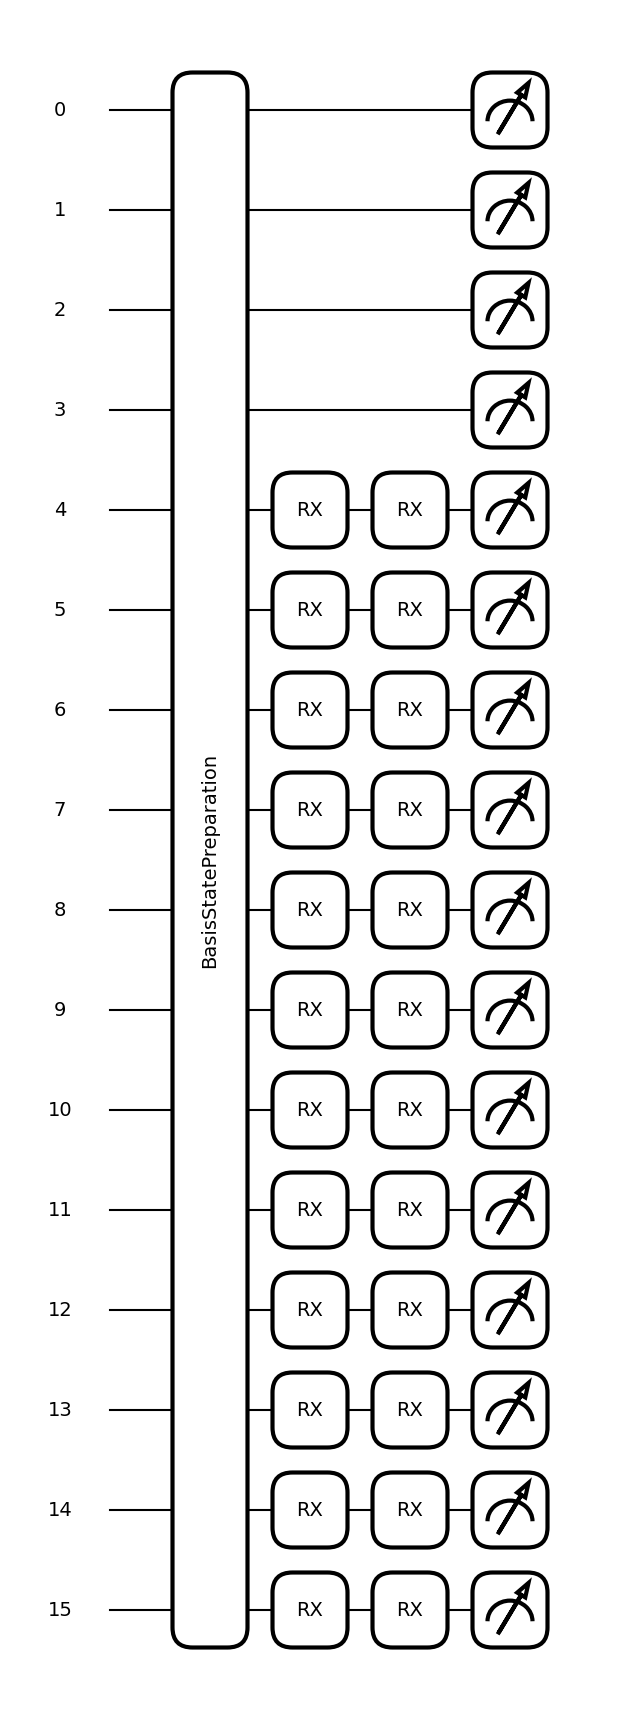

In [10]:
qml.draw_mpl(circuit)(weights, board, empty_rows)

### Start optimazation

In [25]:
# start optimizing weights
optimizer = optim.SGD([weights],lr=0.07,momentum= .9)

loss = []
for it in range(N_iter):
    cost = cost_fn(circuit(weights,board,empty_rows))
    loss.append(float(cost))
    optimizer.zero_grad() #gradient 초기화
    cost.backward() #gradient 계산
    optimizer.step() #함수 개선

## Result

In [26]:
# optimizing이 끝난 후 cost와 board의 상태 출력
state_f = state_vec(weights,board,empty_rows)
exp_val = circuit(weights,board,empty_rows)
exp_board = nomalization(exp_val)
cost = cost_fn(exp_val)

print('cost is : ', float(cost))
print('board is ', np.array(exp_board))
print('weight is ',weights)

cost is :  0.001461593281883475
board is  [[1.4901161e-07 1.4901161e-07 9.9999988e-01 1.4901161e-07]
 [9.9996984e-01 8.0466270e-07 3.1441450e-05 6.8545341e-07]
 [8.0674887e-05 4.2438507e-05 1.0192394e-05 9.9997950e-01]
 [2.5182962e-05 9.9991751e-01 3.3289194e-05 3.2782555e-07]]
weight is  tensor([[ 1.9669, -0.0192, -0.0838,  0.0311, -0.2731, -0.0180, -0.0464,  1.5630,
          0.3999,  1.2521,  0.3642, -0.0519],
        [ 1.1637,  0.0209,  0.0950, -0.0325,  0.2910,  0.0050,  0.0400,  1.5877,
         -0.4099,  1.9077, -0.3757,  0.0527]], requires_grad=True)


### LOSS

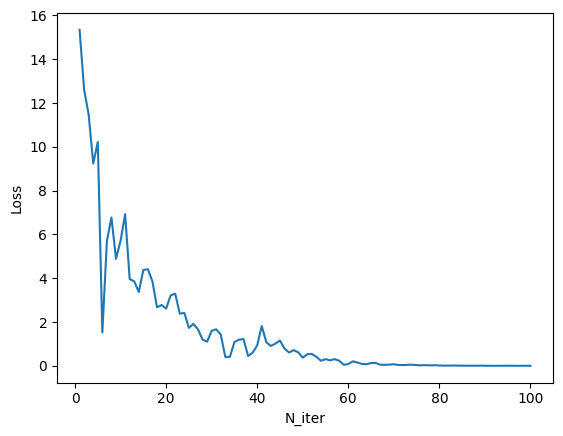

In [27]:
import matplotlib.pyplot as plt

plt.plot(np.arange(1,N_iter+1),loss)
plt.xlabel('N_iter')
plt.ylabel('Loss')
plt.show()

In [28]:
a = torch.argmax(state_f) # 나올 확률이 가장 높은 상태
print(format(a,'016b'),'\nprobablity is ', float(max(state_f))*100,'%')
draw(np.array([int(i) for i in format(a,'016b')]).reshape([4,4]))

0010100000010100 
probablity is  99.96432662010193 %
□□◆□
◆□□□
□□□◆
□◆□□


In [29]:
# expectation_value 
m = np.eye(4,4)
for i in range(4):
    for j in range(4):
        if exp_board[i,j] == max(exp_board[i]):
            m[i,j] = 1
        else:
            m[i,j] = 0
draw(m)

□□◆□
◆□□□
□□□◆
□◆□□


### 개선점
1. state preparation 개선
2. cost 개선
3. entangle을 주기
4. backend 연결
5. 동작 중 local minimun에 걸려 잘못된 결과를 내뱉는 경우가 있음